In [1]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
TF_ENABLE_ONEDNN_OPTS = 0
URLS = CHUNKS_URLS
LIMIT = 60
LARGER_DATASET_PATH = "../larger_dataset"
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/preprocessed_data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
ACTUAL_DATA_SHAPE = 6990280
RANDOM_STATE = 42

In [3]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.
chunk_7 already exists.
chunk_8 already exists.
chunk_9 already exists.
chunk_10 already exists.
chunk_11 already exists.
chunk_12 already exists.
chunk_13 already exists.
chunk_14 already exists.
chunk_15 already exists.
chunk_16 already exists.
chunk_17 already exists.
chunk_18 already exists.
chunk_19 already exists.
chunk_20 already exists.
chunk_21 already exists.
chunk_22 already exists.
chunk_23 already exists.
chunk_24 already exists.
chunk_25 already exists.
chunk_26 already exists.
chunk_27 already exists.
chunk_28 already exists.
chunk_29 already exists.
chunk_30 already exists.
chunk_31 already exists.
chunk_32 already exists.
chunk_33 already exists.
chunk_34 already exists.
chunk_35 already exists.
chunk_36 already exists.
chunk_37 already exists.
chunk_38 already exists.
chunk_39 already exists.
chunk_40 already exists.
chunk_41 

In [4]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [5]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [6]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [7]:
review_data = df[['text', 'stars']].copy()

In [8]:
review_data.reset_index(inplace = True)
review_data.drop(['index'],axis = 1,inplace = True)

In [9]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [10]:
review_data['full_review_text'] = pd.Series([str(text) for text in review_data['full_review_text']])

In [11]:
review_data.isnull().sum()
review_data.dropna(inplace = True)

In [12]:
review_data['full_review_text'].replace('', np.nan, inplace=True)
review_data.dropna(inplace = True)

In [13]:
len(review_data['full_review_text'])

6990280

## Comparisons

In [14]:
X = review_data['full_review_text']
y = review_data['star_rating']

### Sentiment Polarity

In [15]:
if os.path.exists("../pickle_files/sent_data.pickle"):
    sent_data = pickle.load(open("../pickle_files/sent_data.pickle",'rb'))
else:
    sid = SentimentIntensityAnalyzer()
    sent_polarity_info = [sid.polarity_scores(review) for review in review_data['full_review_text']]

In [16]:
if not os.path.exists("../pickle_files/sent_data.pickle"):
    review_sentiment = [classify_sentiment(scores) for scores in sent_polarity_info]
    sent_polarity = [extract_sent_polarity(scores) for scores in sent_polarity_info]
    review_data['str_sent'] = review_sentiment
    review_data['sent_polarity'] = sent_polarity

In [17]:
sentiment_labels = translate_labels(y)
y_true_sent = encode_sent(sentiment_labels)
y_pred_sent = encode_sent(sent_data['str_sent'])

In [18]:
if not os.path.exists("../pickle_files/sent_data.pickle"):
    sent_data = review_data[['str_sent', 'sent_polarity']].copy()
    pickle_out = open("../pickle_files/sent_data.pickle",'wb')
    pickle.dump(sent_data,pickle_out)
    pickle_out.close()

In [19]:
if not os.path.exists("../pickle_files/sent_data.pickle"):
    print(metrics.accuracy_score(y_true_sent,y_pred_sent))

### Machine Learning Models

#### Word Embedding

In [20]:
if not os.path.exists('../pickle_files'):
    os.mkdir('../pickle_files')

In [21]:
count_model = CountVectorizer()

In [22]:
if not os.path.exists("../pickle_files/word2vec_model_sklearn.pickle"):
    print("Creating Embedding From Scratch.")
    word2vec_model_sklearn = count_model.fit_transform(X.apply(lambda x: np.str_(x)))
    pickle_out = open("../pickle_files/word2vec_model_sklearn.pickle",'wb')
    pickle.dump(word2vec_model_sklearn,pickle_out)
    pickle_out.close()
else:
    print("Found Pickle File.")
    word2vec_model_sklearn = pickle.load(open("../pickle_files/word2vec_model_sklearn.pickle",'rb'))

Found Pickle File.


In [23]:
#word2vec_model_sklearn_array = word2vec_model_sklearn.toarray()

In [24]:
x_train,x_test,y_train,y_test = create_train_test_split(word2vec_model_sklearn,y_true_sent,test_size=0.2)

#### Data Resampling

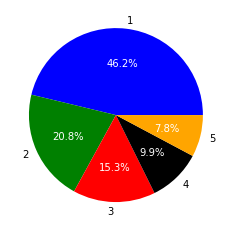

In [25]:
visualize_ratings_pie(y,1,5)

In [31]:
if not os.path.exists("../pickle_files/smote_x_y_train.pickle"):
    random_undersampler = RandomUnderSampler(random_state=RANDOM_STATE)
    x_train,y_train = random_undersampler.fit_resample(x_train,y_train)

In [32]:
if not os.path.exists("../pickle_files/smote_x_y_train.pickle"):
    pickle_out = open("../pickle_files/smote_x_y_train.pickle",'wb')
    pickle.dump({'x_train':x_train,'y_train':y_train},pickle_out)
    pickle_out.close()

#### Training and Results

In [33]:
rf_clf = RandomForestClassifier(n_estimators=25,random_state=RANDOM_STATE)
svm_clf = SVC(kernel='rbf',random_state=RANDOM_STATE)
mnnb_clf = MultinomialNB()
xgb_clf = XGBClassifier(random_state = RANDOM_STATE)

In [ ]:
y_train_xgb,y_test_xgb = adjust_xgb_labels(y_train,y_test)

In [ ]:
rf_clf.fit(x_train,y_train)
y_pred_rf = rf_clf.predict(x_test)
pickle_out = open("../pickle_files/rf.pickle",'wb')
pickle.dump({'rf_clf':rf_clf,'rf_pred':y_pred_rf},pickle_out)
pickle_out.close()

svm_clf.fit(x_train,y_train)
y_pred_svm = svm_clf.predict(x_test)
pickle_out = open("../pickle_files/svm.pickle",'wb')
pickle.dump({'svm_clf':svm_clf,'svm_pred':y_pred_svm},pickle_out)
pickle_out.close()

mnnb_clf.fit(x_train,y_train)
y_pred_mnnb = mnnb_clf.predict(x_test)
pickle_out = open("../pickle_files/mnnb.pickle",'wb')
pickle.dump({'mnnb_clf':mnnb_clf,'mnnb_pred':y_pred_mnnb},pickle_out)
pickle_out.close()

xgb_clf.fit(x_train,y_train_xgb)
y_pred_xgb = xgb_clf.predict(x_test)
pickle_out = open("../pickle_files/xgb.pickle",'wb')
pickle.dump({'xgb_clf':xgb_clf,'xgb_pred':y_pred_xgb},pickle_out)
pickle_out.close()

In [ ]:
show_metrics(rf_clf,x_test,y_test,y_pred_rf,word2vec_model_sklearn,y)
show_metrics(svm_clf,x_test,y_test,y_pred_rf,word2vec_model_sklearn,y)
show_metrics(mnnb_clf,x_test,y_test,y_pred_rf,word2vec_model_sklearn,y)
show_metrics(xgb_clf,x_test,y_test_xgb,y_pred_rf,word2vec_model_sklearn,y)